# Importing libraries and cleaned dataset

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

from functions import prophet_model, df_prophet_prep, outlier_scaling, metrics_calc_clusters,prophet_model_with_clusters,prophet_model_per_product
from functions import prophet_model_per_product_SELECTED_MODEL_returns_forecast, prophet_model_SELECTED_MODEL_returns_forecast, prophet_model_per_product_CLUSTER_SELECTED_MODEL_returns_forecast

# to set logging level to ERROR
# that is because in the model forecasts I was getting updates on time started/ completed and was visually confusing
import logging
import pickle

In [2]:
# to set logging level to ERROR
# that is because in the model forecasts I was getting updates on time started/ completed and was visually confusing
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [3]:
# Disabling a specific type of warning from Jupyter, that I know if mistaken for something else
pd.options.mode.chained_assignment = None 

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [4]:
# Importing dataset, clean and filtered with clusters from the notebook 03_ML_clustering
# the filters on are: only actual products, only UK (90% of the orders), dropping NaN customerID
# At a later stage, I can solve the NaN in CustomerID by building a ML model to predict their Label based on the order(from InvoiceNo) characteristics
file_path = '../data/data_filtered_with_clusters.csv'

df = pd.read_csv(file_path, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])

# Feature Engineering

### Scaling outliers

I know from the EDA, shown in the previous notebooks, **two outliers** with huge difference in scale. I am going to do scaling to a range, scaling them to highest next value (after these two).

In [5]:
# Scaling within a range, updating the Quantity and accordingly the TotalPrice
df = outlier_scaling(df)

### Date column

Adding new column for the date without time.

In [6]:
# New date column without time
df['InvoiceDate_noTime'] = df.InvoiceDate.dt.normalize()

### Removing features that will not be used

I will be using StockCode, Quantity, Date and Labelfor my model. 

In [7]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'Label',
       'InvoiceDate_noTime'],
      dtype='object')

In [8]:
df.drop(columns=['InvoiceNo','Description', 'InvoiceDate','UnitPrice', 
                 'CustomerID', 'Country', 'TotalPrice'],inplace=True)
df.rename(columns={'InvoiceDate_noTime':'InvoiceDate'}, inplace=True)
df.head()

,StockCode,Quantity,Label,InvoiceDate
0,85123A,6,2,2010-12-01
1,71053,6,2,2010-12-01
2,84406B,8,2,2010-12-01
3,84029G,6,2,2010-12-01
4,84029E,6,2,2010-12-01


# Top selling products

In [9]:
# the top selling products
products_top = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).index.tolist()
products_top

['84077',
 '22197',
 '85099B',
 '85123A',
 '84879',
 '22616',
 '17003',
 '21212',
 '22178',
 '21977',
 '15036',
 '22386',
 '23203',
 '21915',
 '22469',
 '84946',
 '85099F',
 '22086',
 '84755',
 '22693',
 '47566',
 '22492',
 '22151',
 '20725',
 '84991',
 '16014',
 '20668',
 '85099C',
 '71459',
 '23199',
 '21790',
 '23084',
 '21213',
 '21175',
 '22952',
 '22998',
 '23201',
 '21137',
 '21181',
 '22961',
 '21931',
 '23209',
 '84568',
 '22659',
 '22969',
 '22993',
 '84978',
 '21326',
 '20727',
 '23202',
 '84992',
 '21975',
 '22411',
 '84945',
 '21108',
 '22423',
 '23310',
 '22470',
 '79321',
 '22383',
 '20971',
 '20713',
 '21498',
 '22577',
 '23206',
 '21928',
 '21703',
 '21080',
 '21929',
 '21166',
 '84212',
 '22910',
 '21232',
 '22578',
 '20728',
 '20724',
 '22988',
 '84947',
 '21497',
 '22610',
 '21985',
 '22189',
 '22384',
 '23307',
 '23344',
 '22457',
 '82482',
 '85152',
 '84970S',
 '23077',
 '16045',
 '23301',
 '23166',
 '84347',
 '22865',
 '22699',
 '21733',
 '23232',
 '21891',
 '227

# Prophet model the Top 1 product

Helpful resource: https://facebook.github.io/prophet/docs/quick_start.html

Regarding the train/test split:
- my dataset has 375 days
- I will use the last part of the dataset as my test model, and I nned to define the number of days that I will consider
- 80% of my dataset is 83 days, and 90% 46.5 days
- since I have a bit more than 12 months of data, I can consider the first 10 months as my train set, and the last 2 months as the test set.

That means that my test set will have the last 60 days, and thus my train set the first 315 days.

### **Top 1 product, no clusters, no outlier clipping**

### Prophet model for the top products

In [10]:
prophet_model_per_product(df, products_top[0],0)

18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing


Instances that needed outlier clipping:  10 , out of total instances:  424


Top 1 product, no clusters, no outlier clipping:
Root Mean Squared Error:  609.3749
Mean Absolute Error:  155.5281


Top 1 product, no clusters, with outlier clipping:
Root Mean Squared Error:  167.2127
Mean Absolute Error:  90.9965


Top 1 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  614.8361
Mean Absolute Error:  152.1632


Top 1 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  32.3399
Mean Absolute Error:  22.4198
Cluster 1:
Root Mean Squared Error:  61.8408
Mean Absolute Error:  45.6321
Cluster 2:
Root Mean Squared Error:  75.5434
Mean Absolute Error:  45.3511
Cluster 3:
Root Mean Squared Error:  610.0817
Mean Absolute Error:  117.1422

Collective metrics for this model:
RMSE:  108.8987 , MAE:  48.5807


Top 1 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  0 , o

In [11]:
prophet_model_per_product(df, products_top[1],1)

Instances that needed outlier clipping:  9 , out of total instances:  965


Top 2 product, no clusters, no outlier clipping:
Root Mean Squared Error:  487.9998
Mean Absolute Error:  235.3251


Top 2 product, no clusters, with outlier clipping:
Root Mean Squared Error:  285.3265
Mean Absolute Error:  173.0273


Top 2 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  503.4385
Mean Absolute Error:  233.3273


Top 2 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  16.1218
Mean Absolute Error:  7.7057
Cluster 1:
Root Mean Squared Error:  70.1693
Mean Absolute Error:  44.1573
Cluster 2:
Root Mean Squared Error:  126.4374
Mean Absolute Error:  70.9576
Cluster 3:
Root Mean Squared Error:  456.1989
Mean Absolute Error:  180.3268

Collective metrics for this model:
RMSE:  121.9279 , MAE:  61.9183


Top 2 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  2 , o

In [12]:
prophet_model_per_product(df, products_top[2],2)

Instances that needed outlier clipping:  20 , out of total instances:  1461


Top 3 product, no clusters, no outlier clipping:
Root Mean Squared Error:  181.4184
Mean Absolute Error:  126.0656


Top 3 product, no clusters, with outlier clipping:
Root Mean Squared Error:  124.9884
Mean Absolute Error:  96.5427


Top 3 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  182.8239
Mean Absolute Error:  118.6261


Top 3 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  9.1556
Mean Absolute Error:  6.21
Cluster 1:
Root Mean Squared Error:  42.1611
Mean Absolute Error:  23.6922
Cluster 2:
Root Mean Squared Error:  35.8415
Mean Absolute Error:  31.9379
Cluster 3:
Root Mean Squared Error:  175.9105
Mean Absolute Error:  109.778

Collective metrics for this model:
RMSE:  54.0092 , MAE:  35.7845


Top 3 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  1 , out of

In [13]:
prophet_model_per_product(df, products_top[3],3)

Instances that needed outlier clipping:  12 , out of total instances:  1936


Top 4 product, no clusters, no outlier clipping:
Root Mean Squared Error:  177.4483
Mean Absolute Error:  91.3589


Top 4 product, no clusters, with outlier clipping:
Root Mean Squared Error:  93.7371
Mean Absolute Error:  63.552


Top 4 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  172.0019
Mean Absolute Error:  77.9187


Top 4 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  11.8713
Mean Absolute Error:  8.794
Cluster 1:
Root Mean Squared Error:  27.3009
Mean Absolute Error:  19.7023
Cluster 2:
Root Mean Squared Error:  28.0888
Mean Absolute Error:  19.8685
Cluster 3:
Root Mean Squared Error:  169.628
Mean Absolute Error:  70.0236

Collective metrics for this model:
RMSE:  35.4052 , MAE:  21.3707


Top 4 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  14 , out of t

In [14]:
prophet_model_per_product(df, products_top[4],4)

Instances that needed outlier clipping:  4 , out of total instances:  1320


Top 5 product, no clusters, no outlier clipping:
Root Mean Squared Error:  189.1148
Mean Absolute Error:  94.8089


Top 5 product, no clusters, with outlier clipping:
Root Mean Squared Error:  113.7963
Mean Absolute Error:  71.341


Top 5 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  189.8075
Mean Absolute Error:  86.241


Top 5 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  19.6208
Mean Absolute Error:  13.1934
Cluster 1:
Root Mean Squared Error:  47.4772
Mean Absolute Error:  29.6143
Cluster 2:
Root Mean Squared Error:  61.1003
Mean Absolute Error:  36.3581
Cluster 3:
Root Mean Squared Error:  163.2501
Mean Absolute Error:  64.3185

Collective metrics for this model:
RMSE:  48.3893 , MAE:  28.705


Top 5 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  6 , out of t

In [15]:
prophet_model_per_product(df, products_top[9],9)

Instances that needed outlier clipping:  10 , out of total instances:  596


Top 10 product, no clusters, no outlier clipping:
Root Mean Squared Error:  73.4211
Mean Absolute Error:  64.8493


Top 10 product, no clusters, with outlier clipping:
Root Mean Squared Error:  55.4825
Mean Absolute Error:  49.5311


Top 10 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  55.4825
Mean Absolute Error:  49.5311


Top 10 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  6.2262
Mean Absolute Error:  4.8704
Cluster 1:
Root Mean Squared Error:  16.7243
Mean Absolute Error:  13.083
Cluster 2:
Root Mean Squared Error:  24.697
Mean Absolute Error:  14.5475
Cluster 3:
Root Mean Squared Error:  63.8144
Mean Absolute Error:  58.7338

Collective metrics for this model:
RMSE:  21.9857 , MAE:  16.7423


Top 10 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  0 , out of t

In [16]:
prophet_model_per_product(df, products_top[19],19)

Instances that needed outlier clipping:  5 , out of total instances:  209


Top 20 product, no clusters, no outlier clipping:
Root Mean Squared Error:  45.9684
Mean Absolute Error:  37.005


Top 20 product, no clusters, with outlier clipping:
Root Mean Squared Error:  34.7791
Mean Absolute Error:  24.7426


Top 20 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  34.7791
Mean Absolute Error:  24.7426


Top 20 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  14.2807
Mean Absolute Error:  8.2942
Cluster 1:
Root Mean Squared Error:  20.1651
Mean Absolute Error:  14.2544
Cluster 2:
Root Mean Squared Error:  21.0183
Mean Absolute Error:  7.2714
Cluster 3:
Root Mean Squared Error:  30.3176
Mean Absolute Error:  28.7206

Collective metrics for this model:
RMSE:  19.5181 , MAE:  12.408


Top 20 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  1 , out of to

In [17]:
prophet_model_per_product(df, products_top[49],49)

Instances that needed outlier clipping:  36 , out of total instances:  715


Top 50 product, no clusters, no outlier clipping:
Root Mean Squared Error:  56.6367
Mean Absolute Error:  49.3062


Top 50 product, no clusters, with outlier clipping:
Root Mean Squared Error:  46.1425
Mean Absolute Error:  41.9781


Top 50 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  54.9144
Mean Absolute Error:  46.4115


Top 50 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  3.8512
Mean Absolute Error:  2.9223
Cluster 1:
Root Mean Squared Error:  12.895
Mean Absolute Error:  10.9831
Cluster 2:
Root Mean Squared Error:  22.3658
Mean Absolute Error:  20.3962
Cluster 3:
Root Mean Squared Error:  45.6956
Mean Absolute Error:  25.7902

Collective metrics for this model:
RMSE:  17.73 , MAE:  14.5228


Top 50 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  0 , out of to

# Plots for presentation

In [18]:
forecast0, m0, test0 = prophet_model_per_product_SELECTED_MODEL_returns_forecast(df, products_top[2],2)

Instances that needed outlier clipping:  20 , out of total instances:  1461


Top 3 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  182.8239
Mean Absolute Error:  118.6261


/var/folders/yt/xx6_vt592x9cgxz0trzlfxp00000gn/T/ipykernel_38099/1047135329.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(test0['ds'], test0['y'], 'ro-', label='Actual Values (Test Set)', color='#3CBDBB')  # Red color


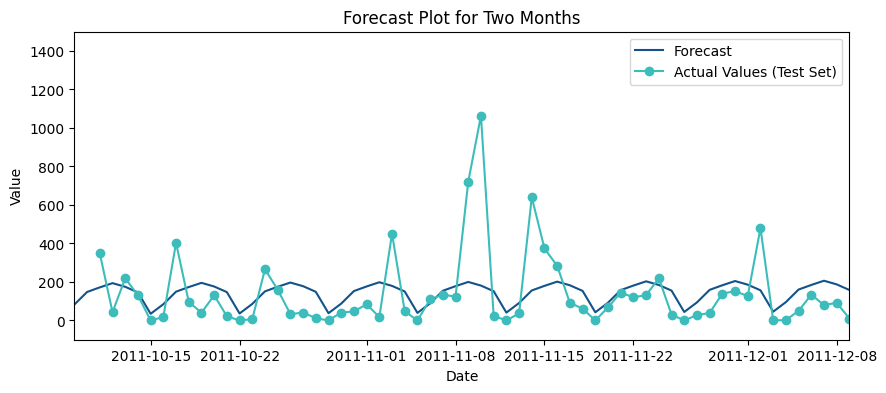

In [19]:
import matplotlib.pyplot as plt

# Plot the forecast for two months
plt.figure(figsize=(10, 4))
plt.plot(forecast0['ds'], forecast0['yhat'], label='Forecast', color='#13538A')  # Blue color

# Plot the actual values from the test set
plt.plot(test0['ds'], test0['y'], 'ro-', label='Actual Values (Test Set)', color='#3CBDBB')  # Red color

# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast Plot for Two Months')

# Set the x-axis limits for one month
plt.xlim(pd.Timestamp('2011-10-09'), pd.Timestamp('2011-12-09'))
plt.ylim(-100, 1500) 

# Show legend
plt.legend()
plt.savefig('../images/forecast_plot0.png')
# Show plot
plt.show()


In [20]:
forecast1, m1, test1,forecast2, m2, test2,forecast3, m3, test3,forecast4, m4, test4 = prophet_model_per_product_CLUSTER_SELECTED_MODEL_returns_forecast(df, products_top[2],2)

Instances that needed outlier clipping:  20 , out of total instances:  1461


Top 3 product, with clusters, with outlier clipping, metrics compared to test set without clipping:
Instances that needed outlier clipping:  1 , out of total instances:  157
Instances that needed outlier clipping:  17 , out of total instances:  631
Instances that needed outlier clipping:  8 , out of total instances:  482
Instances that needed outlier clipping:  3 , out of total instances:  191
Cluster 0:
Root Mean Squared Error:  9.0399
Mean Absolute Error:  6.1829
Cluster 1:
Root Mean Squared Error:  42.4848
Mean Absolute Error:  23.1539
Cluster 2:
Root Mean Squared Error:  32.1045
Mean Absolute Error:  27.2332
Cluster 3:
Root Mean Squared Error:  177.9123
Mean Absolute Error:  106.1644

Collective metrics for this model:
RMSE:  0.0 , MAE:  0.0


In [21]:
label_percentages = [round((df[(df.StockCode==products_top[0])&(df.Label==i)].shape[0]/
                          df[df.StockCode==products_top[0]].shape[0])*100,2) for i in range(4)]
label_percentages

[13.92, 53.3, 24.06, 8.73]

In [22]:
forecast_total_0 = forecast1.copy()
forecast_total_0['yhat'] = forecast1['yhat']*0.1392 +forecast2['yhat']*0.533+forecast3['yhat']*0.2406+forecast4['yhat']*0.873

test_total_0 = test1.copy()
test_total_0['y'] = test1['y']*0.1392 +test2['y']*0.533+test3['y']*0.2406+test4['y']*0.873

/var/folders/yt/xx6_vt592x9cgxz0trzlfxp00000gn/T/ipykernel_38099/2143612773.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(test0['ds'], test0['y'], 'ro-', label='Actual Values (Test Set)', color='#3CBDBB')  # Red color


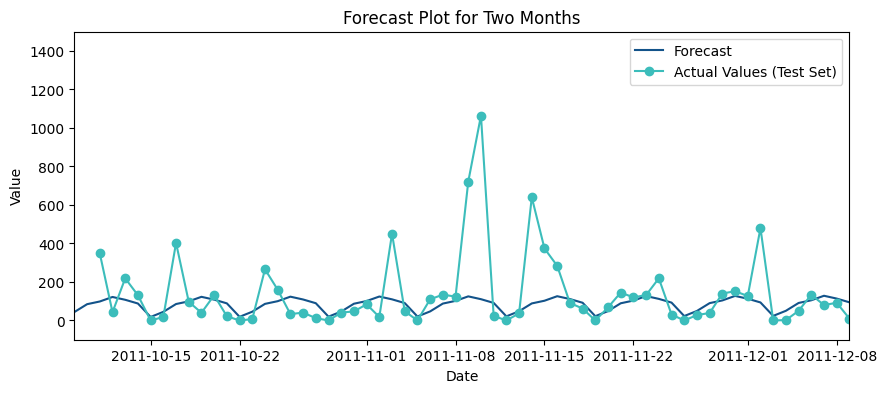

In [23]:
import matplotlib.pyplot as plt

# Plot the forecast for two months
plt.figure(figsize=(10, 4))
plt.plot(forecast_total_0['ds'], forecast_total_0['yhat'], label='Forecast', color='#13538A')  # Blue color

# Plot the actual values from the test set
plt.plot(test0['ds'], test0['y'], 'ro-', label='Actual Values (Test Set)', color='#3CBDBB')  # Red color

# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast Plot for Two Months')

# Set the x-axis limits for one month
plt.xlim(pd.Timestamp('2011-10-09'), pd.Timestamp('2011-12-09'))
plt.ylim(-100, 1500) 

# Show legend
plt.legend()
plt.savefig('../images/forecast_plot1.png')
# Show plot
plt.show()


In [26]:
# Saving model
with open('../models/forecast_model_cl1.pkl', 'wb') as f:
    pickle.dump(forecast1, f)